# LunarLander -v3




In [3]:
import subprocess, sys, importlib.util as iu

def _apt(*args):
    subprocess.run(["apt-get"] + list(args), check=True, capture_output=True)

def _pip(pkg: str):
    subprocess.run([sys.executable, "-m", "pip", "install", pkg, "-q"], check=True)

def setup_environment(box2d: bool = True):
    _apt("update", "-qq")
    _apt("install", "-y", "--no-install-recommends",
         "swig", "build-essential", "python3-dev")


    pip_pkgs = []


    if iu.find_spec("torch") is None:
        pip_pkgs += ["torch", "torchvision"]

    pip_pkgs += ["matplotlib", "numpy", "pygame"]

    if box2d:
        pip_pkgs += ["box2d==2.3.10", "gymnasium[box2d]"]

    for p in pip_pkgs:
        _pip(p)

    return "LunarLander-v3", 8, 4, 200


ENVIRONMENT_NAME, STATE_SIZE, ACTION_SIZE, SOLVED_SCORE = setup_environment()
print(f"환경: {ENVIRONMENT_NAME} | 상태: {STATE_SIZE} | 행동: {ACTION_SIZE} | 목표: {SOLVED_SCORE}")


환경: LunarLander-v3 | 상태: 8 | 행동: 4 | 목표: 200


In [4]:
# 라이브러리 임포트
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# 재현성을 위한 시드 설정
SEED = 43
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"시드: {SEED}")

PyTorch: 2.6.0+cu124
CUDA: True
GPU: Tesla T4
시드: 43


In [ ]:
class ImprovedDuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(ImprovedDuelingDQN, self).__init__()

        # 공통 feature extraction 층
        self.feature_layers = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )

        # Value Stream - 상태의 가치 V(s)를 계산
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, 1)  # 스칼라 값 출력
        )

        # Advantage Stream - 각 행동의 상대적 이득 A(s,a)를 계산
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, action_size)  # 각 행동별 advantage 값
        )



        # Xavier 초기화
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.01)

    def forward(self, x):
        # 공통 특징 추출
        features = self.feature_layers(x)

        # Value와 Advantage를 각각 계산
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)


        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values


In [6]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Experience',
                                   ['state', 'action', 'reward', 'next_state', 'done'])

    def push(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)


In [7]:
class DoubleDQNAgent:
    def __init__(
        self,
        state_size: int,
        action_size: int,
        lr: float = 1e-4,
        gamma: float = 0.99,
        epsilon: float = 1.0,
        epsilon_min: float = 0.01,
        epsilon_decay: float = 0.995,
        buffer_size: int = 50_000,
        batch_size: int = 64,
        warmup_steps: int = 1_000,
        target_update_freq: int = 1_000,
    ):
        # 하이퍼파라미터
        self.state_size, self.action_size = state_size, action_size
        self.gamma = gamma
        self.epsilon, self.epsilon_min, self.epsilon_decay = (
            epsilon, epsilon_min, epsilon_decay
        )
        self.batch_size, self.warmup_steps = batch_size, warmup_steps
        self.target_update_freq = target_update_freq



        self.epsilon_history = []
        self.epsilon_history.append(self.epsilon)

        # 디바이스
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[Agent] device → {self.device}")

        # 네트워크
        self.q_network      = ImprovedDuelingDQN(state_size, action_size).to(self.device)
        self.target_network = ImprovedDuelingDQN(state_size, action_size).to(self.device)
        self.optimizer      = optim.Adam(self.q_network.parameters(), lr=lr)


        self.target_network.load_state_dict(self.q_network.state_dict())

        # 메모리
        self.memory = ReplayBuffer(buffer_size)

        # 통계
        self.learning_steps, self.scores, self.losses = 0, [], []

        print(f"하이퍼파라미터: LR={lr}, ε_decay={epsilon_decay}")
        print(f"예열 스텝: {warmup_steps}, 버퍼 크기: {buffer_size}")


    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)


    def act(self, state: np.ndarray, training: bool = True) -> int:
        if training and random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state_t = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state_t)
        return int(q_values.argmax(dim=1).item())


    def replay(self):
        if len(self.memory) < max(self.warmup_steps, self.batch_size):
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states  = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones   = dones.to(self.device)

        # Double DQN Targets
        q_curr = self.q_network(states).gather(1, actions)
        with torch.no_grad():
            best_actions = self.q_network(next_states).argmax(dim=1, keepdim=True)
            q_next = self.target_network(next_states).gather(1, best_actions)
            targets = rewards + self.gamma * q_next * (1 - dones)

        loss = F.mse_loss(q_curr, targets)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()

        # Hard target update
        self.learning_steps += 1
        if self.learning_steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        self.losses.append(loss.item())
        return loss.item()


    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.epsilon_history.append(self.epsilon)



# 에이전트 생성
agent = DoubleDQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE)

[Agent] device → cuda
하이퍼파라미터: LR=0.0001, ε_decay=0.995
예열 스텝: 1000, 버퍼 크기: 50000


In [8]:
# 환경 생성 및 분석
def create_environment():
        env = gym.make('LunarLander-v3', render_mode='rgb_array')
        env.action_space.seed(SEED)
        return env


# 환경 분석
env = create_environment()
state, _ = env.reset(seed=SEED)

print(f"=== {ENVIRONMENT_NAME}  ===")
print(f"상태 공간: {env.observation_space}")
print(f"행동 공간: {env.action_space}")
print(f"초기 상태: {state}")
print(f"상태 차원: {len(state)}")
print(f"행동 개수: {env.action_space.n}")


print(f"\n LunarLander 상태 변수:")
labels = ["x좌표", "y좌표", "x속도", "y속도", "각도", "각속도", "왼발접촉", "오른발접촉"]
for i, (label, value) in enumerate(zip(labels, state)):
    print(f"  [{i}] {label}: {value:.4f}")

print(f"\n행동: 0=대기, 1=왼쪽엔진, 2=메인엔진, 3=오른쪽엔진")
print(f"목표: 성공적 착륙으로 200+ 점수 달성")

env.close()

=== LunarLander-v3  ===
상태 공간: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
행동 공간: Discrete(4)
초기 상태: [-0.00353403  1.4049611  -0.35797688 -0.26485512  0.00410186  0.08108699
  0.          0.        ]
상태 차원: 8
행동 개수: 4

 LunarLander 상태 변수:
  [0] x좌표: -0.0035
  [1] y좌표: 1.4050
  [2] x속도: -0.3580
  [3] y속도: -0.2649
  [4] 각도: 0.0041
  [5] 각속도: 0.0811
  [6] 왼발접촉: 0.0000
  [7] 오른발접촉: 0.0000

행동: 0=대기, 1=왼쪽엔진, 2=메인엔진, 3=오른쪽엔진
목표: 성공적 착륙으로 200+ 점수 달성


In [9]:
# 학습 설정
EPISODES = 1200
MAX_STEPS = 1000
PRINT_FREQ = 50

# GPU 최적화
if torch.cuda.is_available():
    agent.batch_size = 128


print(f"총 에피소드: {EPISODES}")
print(f"최대 스텝: {MAX_STEPS}")
print(f"목표 점수: {SOLVED_SCORE}")
print(f"예열 스텝: {agent.warmup_steps}")
print(f"배치 크기: {agent.batch_size}")

총 에피소드: 1200
최대 스텝: 1000
목표 점수: 200
예열 스텝: 1000
배치 크기: 128


In [10]:
# 메인 학습 루프
def train_double_dqn():
    env = create_environment()

    scores_window = deque(maxlen=100)
    best_score = -float('inf')
    solved = False
    total_steps = 0

    for episode in range(1, EPISODES + 1):
        state, _ = env.reset(seed=SEED + episode)
        total_reward = 0
        steps = 0
        episode_loss = []

        for step in range(MAX_STEPS):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.remember(state, action, reward, next_state, done)

            # 예열 후 학습
            if total_steps >= agent.warmup_steps:
                loss = agent.replay()
                if loss is not None:
                    episode_loss.append(loss)

            state = next_state
            total_reward += reward
            steps += 1
            total_steps += 1

            if done:
                break

        # Epsilon 감쇠
        agent.decay_epsilon()

        # 점수 기록
        agent.scores.append(total_reward)
        scores_window.append(total_reward)

        if total_reward > best_score:
            best_score = total_reward

        # 진행상황 출력
        if episode % PRINT_FREQ == 0 or episode == 1:
            avg_score = np.mean(scores_window)
            avg_loss = np.mean(episode_loss) if episode_loss else 0


            print(f"Ep {episode:4d} | "
                  f"Score: {total_reward:7.2f} | "
                  f"Avg: {avg_score:7.2f} | "
                  f"Best: {best_score:7.2f} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"ε: {agent.epsilon:.3f}")

            # 목표 달성 확인
            if len(scores_window) >= 100 and avg_score >= SOLVED_SCORE and not solved:
                solved = True
                break



    # 학습 완료
    print(f"Best Score: {best_score:.2f}")
    print(f"Avg: {np.mean(scores_window):.2f}")
    print(f"Learning Steps: {agent.learning_steps:,}")

    env.close()
    return solved, np.mean(scores_window)

# 학습 실행
solved, final_avg = train_double_dqn()

Ep    1 | Score: -468.11 | Avg: -468.11 | Best: -468.11 | Loss: 0.0000 | ε: 0.995
Ep   50 | Score: -176.63 | Avg: -157.85 | Best:   61.14 | Loss: 49.8814 | ε: 0.778
Ep  100 | Score:  -47.17 | Avg: -122.69 | Best:   61.14 | Loss: 20.9391 | ε: 0.606
Ep  150 | Score:  -59.50 | Avg:  -84.14 | Best:   61.14 | Loss: 24.3317 | ε: 0.471
Ep  200 | Score:  -29.05 | Avg:  -71.43 | Best:   61.14 | Loss: 26.9269 | ε: 0.367
Ep  250 | Score:   -2.07 | Avg:  -23.90 | Best:  218.31 | Loss: 13.3681 | ε: 0.286
Ep  300 | Score:   28.70 | Avg:   52.63 | Best:  268.16 | Loss: 6.0676 | ε: 0.222
Ep  350 | Score: -101.16 | Avg:  124.38 | Best:  301.47 | Loss: 12.9952 | ε: 0.173
Ep  400 | Score:  255.90 | Avg:  186.79 | Best:  310.14 | Loss: 14.7811 | ε: 0.135
Ep  450 | Score:  275.68 | Avg:  230.19 | Best:  310.14 | Loss: 15.5775 | ε: 0.105
Best Score: 310.14
Avg: 230.19
Learning Steps: 189,575


=== 최종 결과 ===


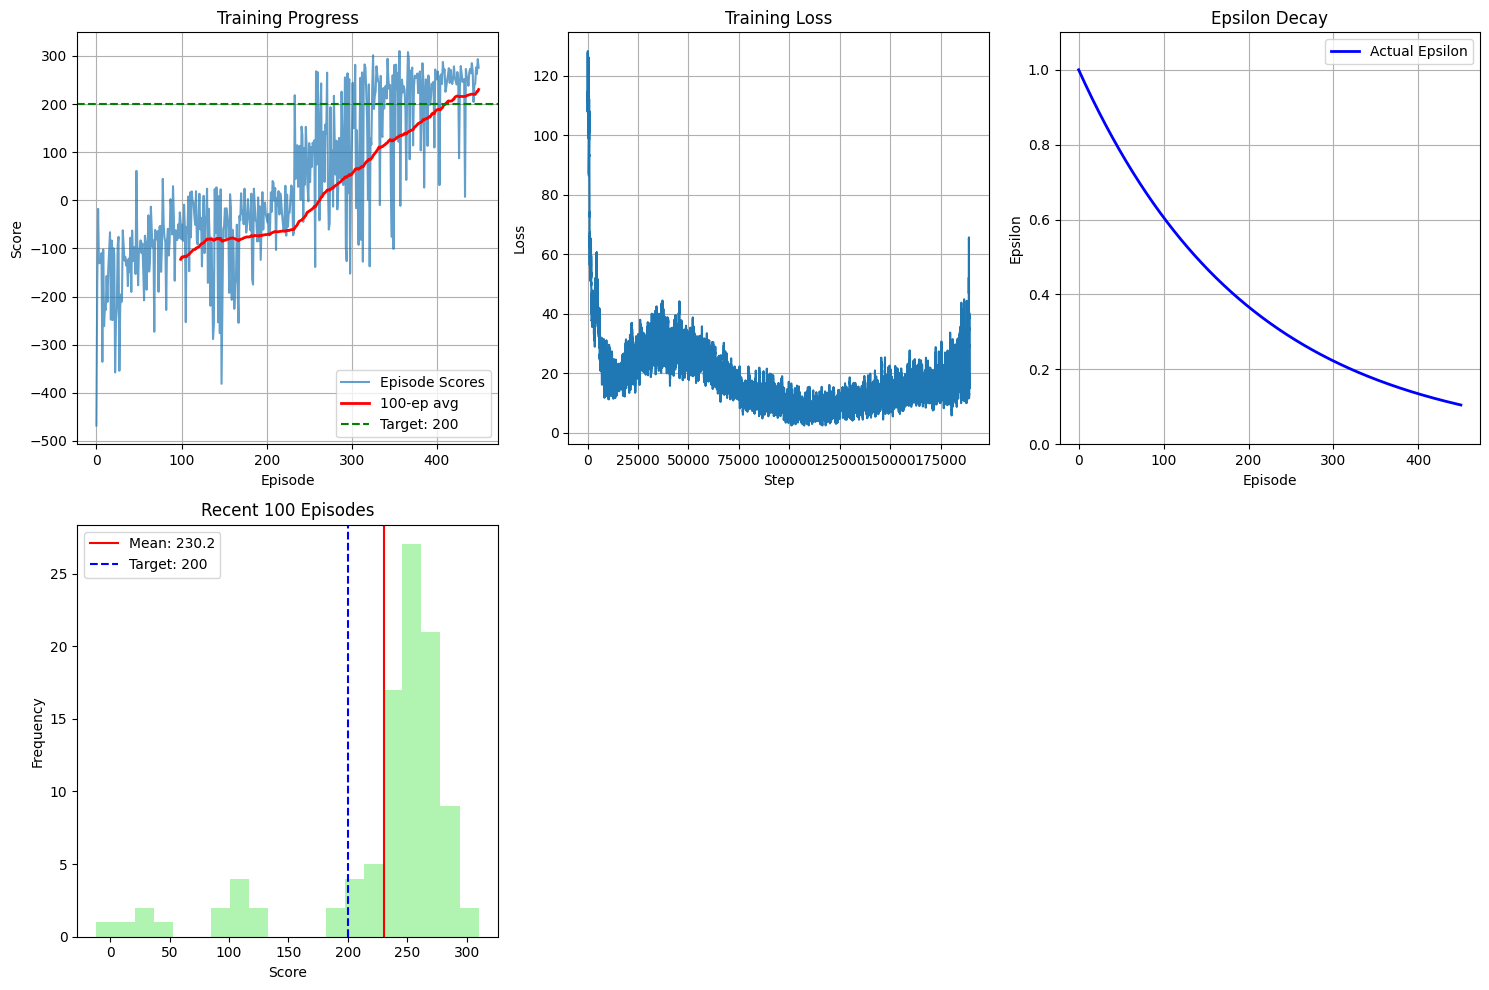

총 에피소드: 450
최고 점수: 310.14
전체 평균: 37.24
최근 100에피소드: 230.19
총 학습 스텝: 189,575
최종 Epsilon: 0.1048


In [11]:
# 최종 결과 분석
print(f"=== 최종 결과 ===")

# 종합 그래프
plt.figure(figsize=(15, 10))

# 점수 그래프
plt.subplot(2, 3, 1)
plt.plot(agent.scores, alpha=0.7, label='Episode Scores')
if len(agent.scores) > 100:
    moving_avg = np.convolve(agent.scores, np.ones(100)/100, mode='valid')
    plt.plot(range(99, len(agent.scores)), moving_avg, 'r-', linewidth=2, label='100-ep avg')
    plt.axhline(y=SOLVED_SCORE, color='g', linestyle='--', label=f'Target: {SOLVED_SCORE}')
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(2, 3, 2)
if len(agent.losses) > 100:
    losses_smooth = np.convolve(agent.losses, np.ones(100)/100, mode='valid')
    plt.plot(losses_smooth)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)

# Epsilon 감쇠
plt.subplot(2, 3, 3)

if hasattr(agent, 'epsilon_history') and len(agent.epsilon_history) > 0:
    num_episodes = len(agent.scores) if hasattr(agent, 'scores') else len(agent.epsilon_history)

    if hasattr(agent, 'get_epsilon_history_for_episodes'):
        epsilon_values = agent.get_epsilon_history_for_episodes(num_episodes)
        episodes = range(num_episodes)
    else:
        # 변화 횟수로 그리기
        episodes = range(len(agent.epsilon_history))
        epsilon_values = agent.epsilon_history

    plt.plot(episodes, epsilon_values, 'b-', linewidth=2, label='Actual Epsilon')
    plt.legend()

plt.title('Epsilon Decay')
plt.xlabel('Episode' if hasattr(agent, 'scores') else 'Decay Step')
plt.ylabel('Epsilon')
plt.grid(True)
plt.ylim(0, 1.1)


# 최근 100에피소드 분포
if len(agent.scores) >= 100:
    plt.subplot(2, 3, 4)
    recent_scores = agent.scores[-100:]
    plt.hist(recent_scores, bins=20, alpha=0.7, color='lightgreen')
    plt.axvline(x=np.mean(recent_scores), color='red', linestyle='-',
               label=f'Mean: {np.mean(recent_scores):.1f}')
    plt.axvline(x=SOLVED_SCORE, color='blue', linestyle='--',
               label=f'Target: {SOLVED_SCORE}')
    plt.title('Recent 100 Episodes')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()



plt.tight_layout()
plt.show()

# 상세 통계
scores = np.array(agent.scores)
print(f"총 에피소드: {len(scores):,}")
print(f"최고 점수: {np.max(scores):.2f}")
print(f"전체 평균: {np.mean(scores):.2f}")
print(f"최근 100에피소드: {np.mean(scores[-100:]):.2f}")
print(f"총 학습 스텝: {agent.learning_steps:,}")
print(f"최종 Epsilon: {agent.epsilon:.4f}")


In [13]:
# 학습된 에이전트 테스트
def test_agent(episodes=50):
    print(f"=== 에이전트 테스트 ({episodes}회) ===")

    test_env = gym.make(ENVIRONMENT_NAME, render_mode=None)
    test_scores = []
    success_count = 0

    for episode in range(episodes):
        state, _ = test_env.reset(seed=SEED + 1000 + episode)
        total_reward = 0
        steps = 0

        while True:
            action = agent.act(state, training=False)
            state, reward, terminated, truncated, _ = test_env.step(action)
            total_reward += reward
            steps += 1

            if terminated or truncated or steps >= MAX_STEPS:
                break

        test_scores.append(total_reward)

        # 성공 판정
        success = total_reward >= SOLVED_SCORE
        if success:
            success_count += 1

        print(f"Test {episode+1:2d}:  | Score: {total_reward:7.2f} | Steps: {steps:3d}")

    test_env.close()

    # 테스트 결과
    test_scores = np.array(test_scores)
    print(f"\n=== 테스트 결과 ===")
    print(f"평균 점수: {np.mean(test_scores):.2f} ± {np.std(test_scores):.2f}")
    print(f"최고 점수: {np.max(test_scores):.2f}")
    print(f"성공률: {success_count}/{episodes} ({success_count/episodes*100:.1f}%)")


    return test_scores

# 테스트 실행
test_results = test_agent(50)

=== 에이전트 테스트 (50회) ===
Test  1:  | Score:  244.73 | Steps: 212
Test  2:  | Score:  189.96 | Steps: 311
Test  3:  | Score:  289.15 | Steps: 365
Test  4:  | Score:  133.01 | Steps: 1000
Test  5:  | Score:  285.02 | Steps: 585
Test  6:  | Score:  265.31 | Steps: 305
Test  7:  | Score:  249.46 | Steps: 259
Test  8:  | Score:  252.64 | Steps: 230
Test  9:  | Score:  294.50 | Steps: 260
Test 10:  | Score:  262.66 | Steps: 262
Test 11:  | Score:   97.26 | Steps: 1000
Test 12:  | Score:  280.38 | Steps: 281
Test 13:  | Score:  219.50 | Steps: 431
Test 14:  | Score:  264.41 | Steps: 244
Test 15:  | Score:  151.57 | Steps: 1000
Test 16:  | Score:  220.36 | Steps: 351
Test 17:  | Score:  160.91 | Steps: 1000
Test 18:  | Score:  222.05 | Steps: 299
Test 19:  | Score:  259.91 | Steps: 228
Test 20:  | Score:  267.86 | Steps: 201
Test 21:  | Score:  178.21 | Steps: 372
Test 22:  | Score:  221.16 | Steps: 317
Test 23:  | Score:  203.23 | Steps: 494
Test 24:  | Score:  250.15 | Steps: 235
Test 25:  | S